In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

In [2]:
all_data = pd.read_csv("data/white_stork_tracking.csv")

/var/folders/5q/01tqbn6d2bn07z8n_c06sz400000gn/T/ipykernel_1113/3191329926.py:1: DtypeWarning: Columns (5,12,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("white_stork_tracking.csv")


In [3]:
all_data.columns

Index(['event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
       'algorithm-marked-outlier', 'argos:altitude', 'argos:best-level',
       'argos:calcul-freq', 'argos:iq', 'argos:lat1', 'argos:lat2', 'argos:lc',
       'argos:lon1', 'argos:lon2', 'argos:nb-mes', 'argos:nb-mes-120',
       'argos:nopc', 'argos:pass-duration', 'argos:sensor-1', 'argos:sensor-2',
       'argos:sensor-3', 'argos:sensor-4', 'argos:valid-location-algorithm',
       'argos:valid-location-manual', 'ground-speed', 'heading', 'height-raw',
       'manually-marked-outlier', 'manually-marked-valid', 'sensor-type',
       'individual-taxon-canonical-name', 'tag-local-identifier',
       'individual-local-identifier', 'study-name'],
      dtype='object')

### Data cleaning

Remove all outliers (3 rows).

In [4]:
all_data = all_data[all_data['algorithm-marked-outlier'] != True]

In [5]:
columns_to_incl = ['event-id', 'timestamp', 'location-long', 'location-lat', 'argos:altitude', 'ground-speed', 'heading', 'height-raw','tag-local-identifier',
       'individual-local-identifier']

filter_data = all_data.filter(items = columns_to_incl)

filter_data.head()

,event-id,timestamp,location-long,location-lat,argos:altitude,ground-speed,heading,height-raw,tag-local-identifier,individual-local-identifier
0,156138797,2010-06-16 15:00:00.000,-6.16917,37.21033,NaN,NaN,NaN,NaN,90964,90964B
1,156138798,2010-06-16 19:00:00.000,-6.16917,37.21033,NaN,NaN,NaN,NaN,90964,90964B
2,156138799,2010-06-17 05:00:00.000,-6.16917,37.21017,NaN,NaN,NaN,NaN,90964,90964B
3,156138800,2010-06-17 08:00:00.000,-6.16917,37.21033,NaN,NaN,NaN,NaN,90964,90964B
4,156138801,2010-06-17 12:00:00.000,-6.16917,37.21033,NaN,NaN,NaN,NaN,90964,90964B


In [6]:
filter_data.shape

(181014, 10)

In [7]:
filter_data.dtypes

event-id                         int64
timestamp                       object
location-long                  float64
location-lat                   float64
argos:altitude                 float64
ground-speed                   float64
heading                        float64
height-raw                      object
tag-local-identifier             int64
individual-local-identifier     object
dtype: object

In [8]:
#Convert timestamp to datetime object
filter_data['timestamp'] = pd.to_datetime(filter_data['timestamp'])

In [9]:
#Convert all non-numeric values in column 'height-raw' to NaN
filter_data['height-raw'] = pd.to_numeric(filter_data['height-raw'], errors='coerce')

In [10]:
#Missing values
filter_data.isna().sum()

event-id                            0
timestamp                           0
location-long                       0
location-lat                        0
argos:altitude                  79572
ground-speed                   163393
heading                        163393
height-raw                     164805
tag-local-identifier                0
individual-local-identifier         0
dtype: int64

In [11]:
#Set timestamp as the index
filter_data.set_index('timestamp', inplace=True)

In [12]:
filter_data.tail()

,event-id,location-long,location-lat,argos:altitude,ground-speed,heading,height-raw,tag-local-identifier,individual-local-identifier
timestamp,,,,,,,,,
2010-08-03 14:10:51,238833855,-6.097,37.213,52.0,NaN,NaN,NaN,90966,90966B
2010-08-03 14:13:19,238833856,-6.152,37.243,78.0,NaN,NaN,NaN,90966,90966B
2010-08-03 16:49:18,238833857,-6.196,37.213,77.0,NaN,NaN,NaN,90966,90966B
2010-08-24 02:31:06,238833866,-6.358,37.446,117.0,NaN,NaN,NaN,90966,90966B
2010-08-24 09:13:11,238833867,-6.424,37.348,53.0,NaN,NaN,NaN,90966,90966B


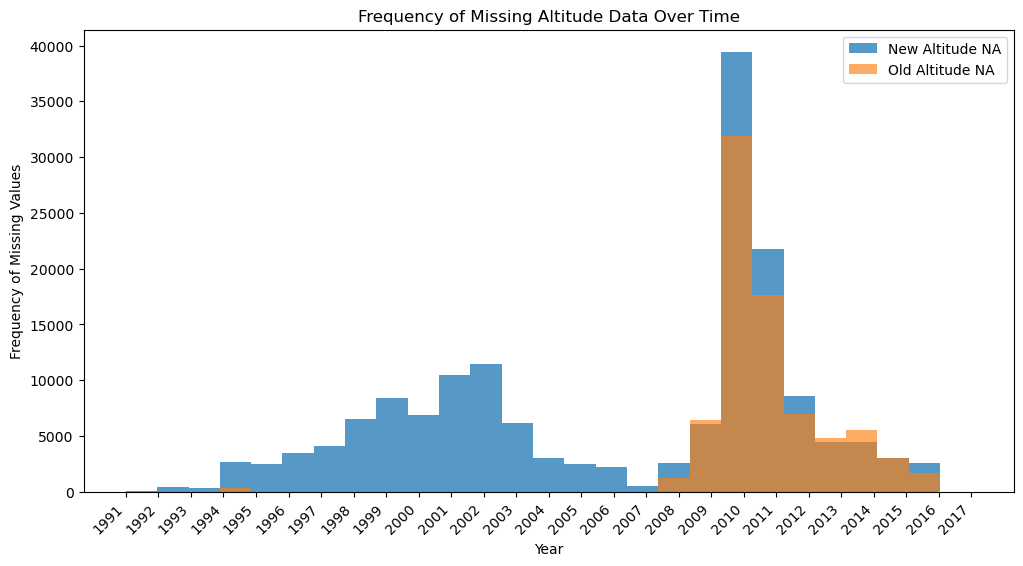

In [13]:
#Due to the extensive period of the study, altitude info is divided between 'argos:altitude' and 'height-raw'

#Calculate yearly missing values for both altitude columns
yearly_missing_alt1 = filter_data['argos:altitude'].isna().resample('Y').sum()
yearly_missing_alt2 = filter_data['height-raw'].isna().resample('Y').sum()

#Get the years for x-ticks (assuming the index is datetime)
years = [year.year for year in yearly_missing_alt1.index]

plt.figure(figsize=(12, 6))


plt.hist(yearly_missing_alt2.index.year, weights=yearly_missing_alt2.values,
         bins=len(years), alpha=0.75, label='New Altitude NA')


plt.hist(yearly_missing_alt1.index.year, weights=yearly_missing_alt1.values,
         bins=len(years), alpha=0.65, label='Old Altitude NA')


plt.xticks(years)
plt.gca().set_xticklabels(years, rotation=45, ha='right')

plt.xlabel('Year')
plt.ylabel('Frequency of Missing Values')
plt.title('Frequency of Missing Altitude Data Over Time')
plt.legend()

# Show the plot
plt.show()

In [14]:
#Check for non-missing values in both altitude columns
both_present = filter_data['argos:altitude'].notna() & filter_data['height-raw'].notna()

# To count the number of instances where both are present
num_both_present = both_present.sum()
print(f"Number of instances where both altitudes are present: {num_both_present}")

Number of instances where both altitudes are present: 0


In [15]:
#This finding allows us to combine the altitude data into one column

filter_data['altitude'] = np.where(
    pd.notnull(filter_data['argos:altitude']), filter_data['argos:altitude'], filter_data['height-raw']
)

filter_data = filter_data.drop(columns=['argos:altitude', 'height-raw'])

In [16]:
print(f"Now {100 - round((filter_data.isna().sum()['altitude'] / filter_data.shape[0]) * 100, 2)}% of records have altitude data!")

Now 65.0% of records have altitude data!


In [17]:
#Extract the year from the date
filter_data['year'] = filter_data.index.year

#Group by individual ID and year, then count the instances
individual_year_counts = filter_data.groupby(['individual-local-identifier', 'year']).size().reset_index(name='count')

#Pivot the result to get the individual-year matrix
individual_year_matrix = individual_year_counts.pivot(index='individual-local-identifier', columns='year', values='count').fillna(0).astype(int)

In [18]:
#There are multiple individuals who have GPS data from different years

individual_year_matrix

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
individual-local-identifier,,,,,,,,,,,,,,,,,,,,,
13015A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13016A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13017A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13018A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13019A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91931B,0,0,0,0,0,0,0,0,0,0,...,0,0,1298,2731,2755,2775,2709,2438,2541,15
93411A,0,0,0,0,0,0,0,0,0,0,...,0,2576,3899,2491,29,0,0,0,0,0
93412A,0,0,0,0,0,0,0,0,0,0,...,0,2619,3216,1608,0,0,0,0,0,0


In [19]:
#filter_data.to_csv('data/stork_tracking_filter.csv')

In [20]:
#In order to make the later dashboard creation easier we only plan to keep one one record per individual per day

#Group by individual ID and date, then take the last entry for each group
data_one_per_day = filter_data.groupby(['individual-local-identifier', filter_data.index.date]).tail(1)

data_one_per_day.shape

(35254, 9)

In [21]:
#Since some individuals wear the tracker for multiple years, it is good to have an additional column of IDs,
#Where the ID also has year number behind it

data_one_per_day['id_year'] = data_one_per_day['individual-local-identifier'].astype(str) + '_' + data_one_per_day.index.year.astype(str)

/var/folders/5q/01tqbn6d2bn07z8n_c06sz400000gn/T/ipykernel_1113/896559757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one_per_day['id_year'] = data_one_per_day['individual-local-identifier'].astype(str) + '_' + data_one_per_day.index.year.astype(str)


In [22]:
#data_one_per_day.to_csv('data/stork_tracking_1perday.csv')

In [23]:
data_one_per_day.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year
timestamp,,,,,,,,,,
2010-06-16 19:00:00,156138798,-6.16917,37.21033,NaN,NaN,90964,90964B,NaN,2010,90964B_2010
2010-06-17 19:00:00,156138803,-6.16917,37.21033,NaN,NaN,90964,90964B,NaN,2010,90964B_2010
2010-06-19 19:00:00,156138810,-6.16917,37.21033,NaN,NaN,90964,90964B,NaN,2010,90964B_2010
2010-06-20 19:00:00,156138815,-6.16917,37.21033,NaN,NaN,90964,90964B,NaN,2010,90964B_2010
2010-06-22 19:00:00,156138824,-6.16917,37.21033,NaN,NaN,90964,90964B,NaN,2010,90964B_2010


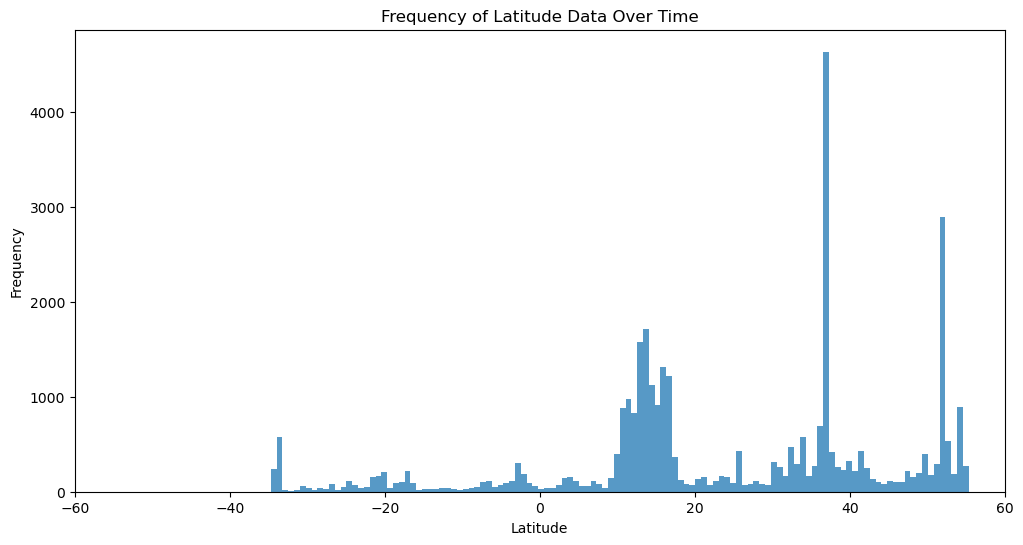

In [24]:
#There seems to be something wrong with plotting the trails of birds and GPS coordinates

plt.figure(figsize=(12, 6))

plt.hist(data_one_per_day['location-lat'], bins = 120, alpha=0.75)
plt.xlim(-60,60)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Frequency of Latitude Data Over Time')
plt.show()

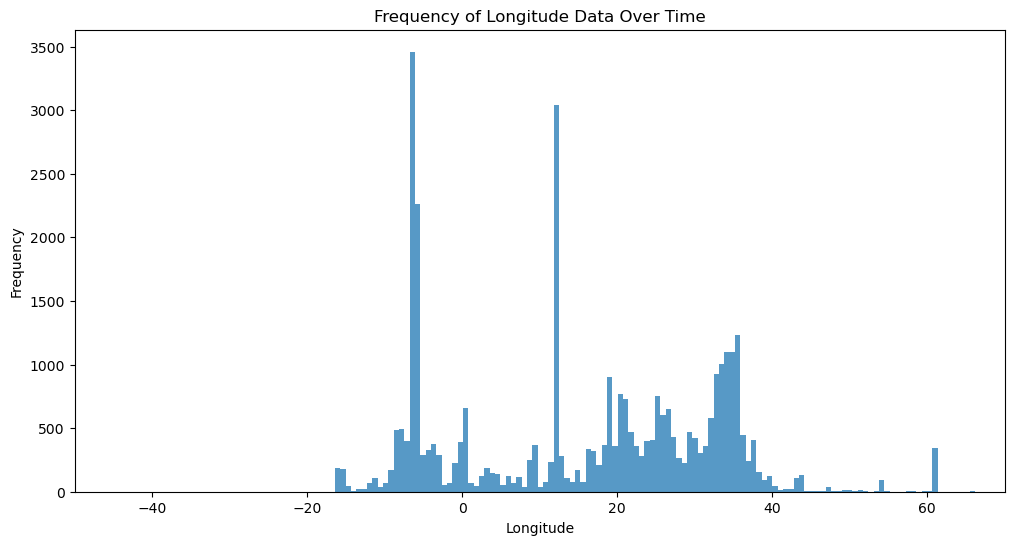

In [25]:
plt.figure(figsize=(12, 6))

plt.hist(data_one_per_day['location-long'], bins = 120, alpha=0.75)
plt.xlim(-50,70)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Frequency of Longitude Data Over Time')
plt.show()

Although the distributions of location coordinates have peculiar peaks, it is hard to assess if anything should be corrected here. In order to fix the weird "jumps" on trail paths while mapping, instances with location differences above 1000km from the last recorded location will be removed.   

In [26]:
from geopy.distance import geodesic

data_one_per_day_filter = data_one_per_day.copy()

data_one_per_day_filter.sort_values(by=['individual-local-identifier', 'timestamp'], inplace=True)

In [27]:
#Function to calculate distance
def calculate_distance(row, prev_row):
    if row['individual-local-identifier'] == prev_row['individual-local-identifier']:
        return geodesic((prev_row['location-lat'], prev_row['location-long']), (row['location-lat'], row['location-long'])).kilometers
    return 0

In [28]:
#Initialize previous row and list to store distances
prev_row = data_one_per_day_filter.iloc[0]
distances = [0] 

In [29]:
#Calculate distances for each row
for i in range(1, len(data_one_per_day_filter)):
    prev_row = data_one_per_day_filter.iloc[i - 1]
    row = data_one_per_day_filter.iloc[i]
    distance = calculate_distance(row, prev_row)
    distances.append(distance)

data_one_per_day_filter['distance_from_last'] = distances

In [30]:
data_one_per_day_filter.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last
timestamp,,,,,,,,,,,
2001-05-25 21:44:15,155977183,12.050,52.095,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,0.000000
2001-05-26 17:00:28,155977205,12.090,52.120,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,3.904943
2001-05-27 07:31:25,155977222,12.090,52.082,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,4.228232
2001-07-19 16:53:17,155977247,20.785,55.085,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,665.140144
2001-08-04 15:23:24,155977265,49.801,53.235,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,1892.721501


Count the instances for each individual where the daily distance has been above 1000km.

In [31]:
distance_counts = data_one_per_day_filter[data_one_per_day_filter['distance_from_last'] > 1000].groupby('individual-local-identifier').size()

print(distance_counts)
print()
print(f"{distance_counts.sum()} days along {len(distance_counts)} 'individuals' with distances above 1000 kilometers.")

individual-local-identifier
13015A          1
13016A          1
13017A          1
13018A          1
13019A          1
13020A          1
13021A          1
13022A          1
14542E          1
14550F          1
14552E          1
14554G          1
14555D          3
14555G          2
14556D          1
14556F          1
14557A          2
14559H          2
16896A          7
16907A          1
20525E          1
40534C          1
54983B          1
77195A          1
8883D           1
90965B          1
93411A          3
Prinz           2
Prinzesschen    1
dtype: int64

43 days along 29 'individuals' with distances above 1000 kilometers.


In [32]:
data_one_per_day_filter[data_one_per_day_filter['distance_from_last'] > 1000]

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last
timestamp,,,,,,,,,,,
2001-08-04 15:23:24,155977265,49.80100,53.23500,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,1892.721501
2001-08-04 15:20:58,156085536,49.85700,53.23600,NaN,NaN,13016,13016A,0.0,2001,13016A_2001,1890.722539
2001-08-04 15:23:31,155915482,49.85100,53.24400,NaN,NaN,13017,13017A,0.0,2001,13017A_2001,1893.171310
2001-08-07 10:05:27,156116470,51.06300,51.85500,NaN,NaN,13018,13018A,0.0,2001,13018A_2001,2023.478482
2001-08-04 13:44:21,156008245,49.31000,53.64400,NaN,NaN,13019,13019A,0.0,2001,13019A_2001,1846.131838
2001-08-04 17:41:32,155990540,49.27100,53.67300,NaN,NaN,13020,13020A,0.0,2001,13020A_2001,1839.897282
2001-08-06 17:22:17,156115083,48.51500,52.64300,NaN,NaN,13021,13021A,0.0,2001,13021A_2001,1840.367854
2001-08-04 15:21:23,155968901,43.86600,52.63800,NaN,NaN,13022,13022A,0.0,2001,13022A_2001,1532.218631
2002-03-16 14:33:28,155923326,5.38600,45.85100,NaN,NaN,14542,14542E,0.0,2002,14542E_2002,1115.965731


In [33]:
#Let's remove those rows (although some of them are borderline suspicious)

data_one_per_day_filter = data_one_per_day_filter[data_one_per_day_filter['distance_from_last'] < 1000]

Some of the individual + year combinations only have a few locations and no real migration paths. Let's remove the combinations with 90 or less days of data.

In [34]:
individual_counts_filter = data_one_per_day_filter.groupby(['id_year']).size()

In [35]:
individual_counts_filter

id_year
13015A_2001          106
13015A_2002          235
13015A_2003           24
13016A_2001           17
13017A_2001           16
                    ... 
Prinzesschen_2002    265
Prinzesschen_2003    272
Prinzesschen_2004    259
Prinzesschen_2005    358
Prinzesschen_2006    327
Length: 352, dtype: int64

In [36]:
print(f"We have {len(individual_counts_filter)} \'individuals\' and {(individual_counts_filter < 90).sum()} of them have less than 90 days of data.")

We have 352 'individuals' and 200 of them have less than 90 days of data.


Let us remove the data about those individuals as well to better analyse the migration behaviour.

In [37]:
valid_id_years = individual_counts_filter[individual_counts_filter >= 90].index

data_one_per_day_filter = data_one_per_day_filter[data_one_per_day_filter['id_year'].isin(valid_id_years)]

There are still some year+id combinations that are basically stationary or move very little through time and something has probably hapened with the GPS tracker. Let's filter out those 'individuals'.

In [38]:
data_one_per_day_filter.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last
timestamp,,,,,,,,,,,
2001-05-25 21:44:15,155977183,12.050,52.095,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,0.000000
2001-05-26 17:00:28,155977205,12.090,52.120,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,3.904943
2001-05-27 07:31:25,155977222,12.090,52.082,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,4.228232
2001-07-19 16:53:17,155977247,20.785,55.085,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,665.140144
2001-08-05 14:59:02,155977271,49.973,53.253,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,11.655827


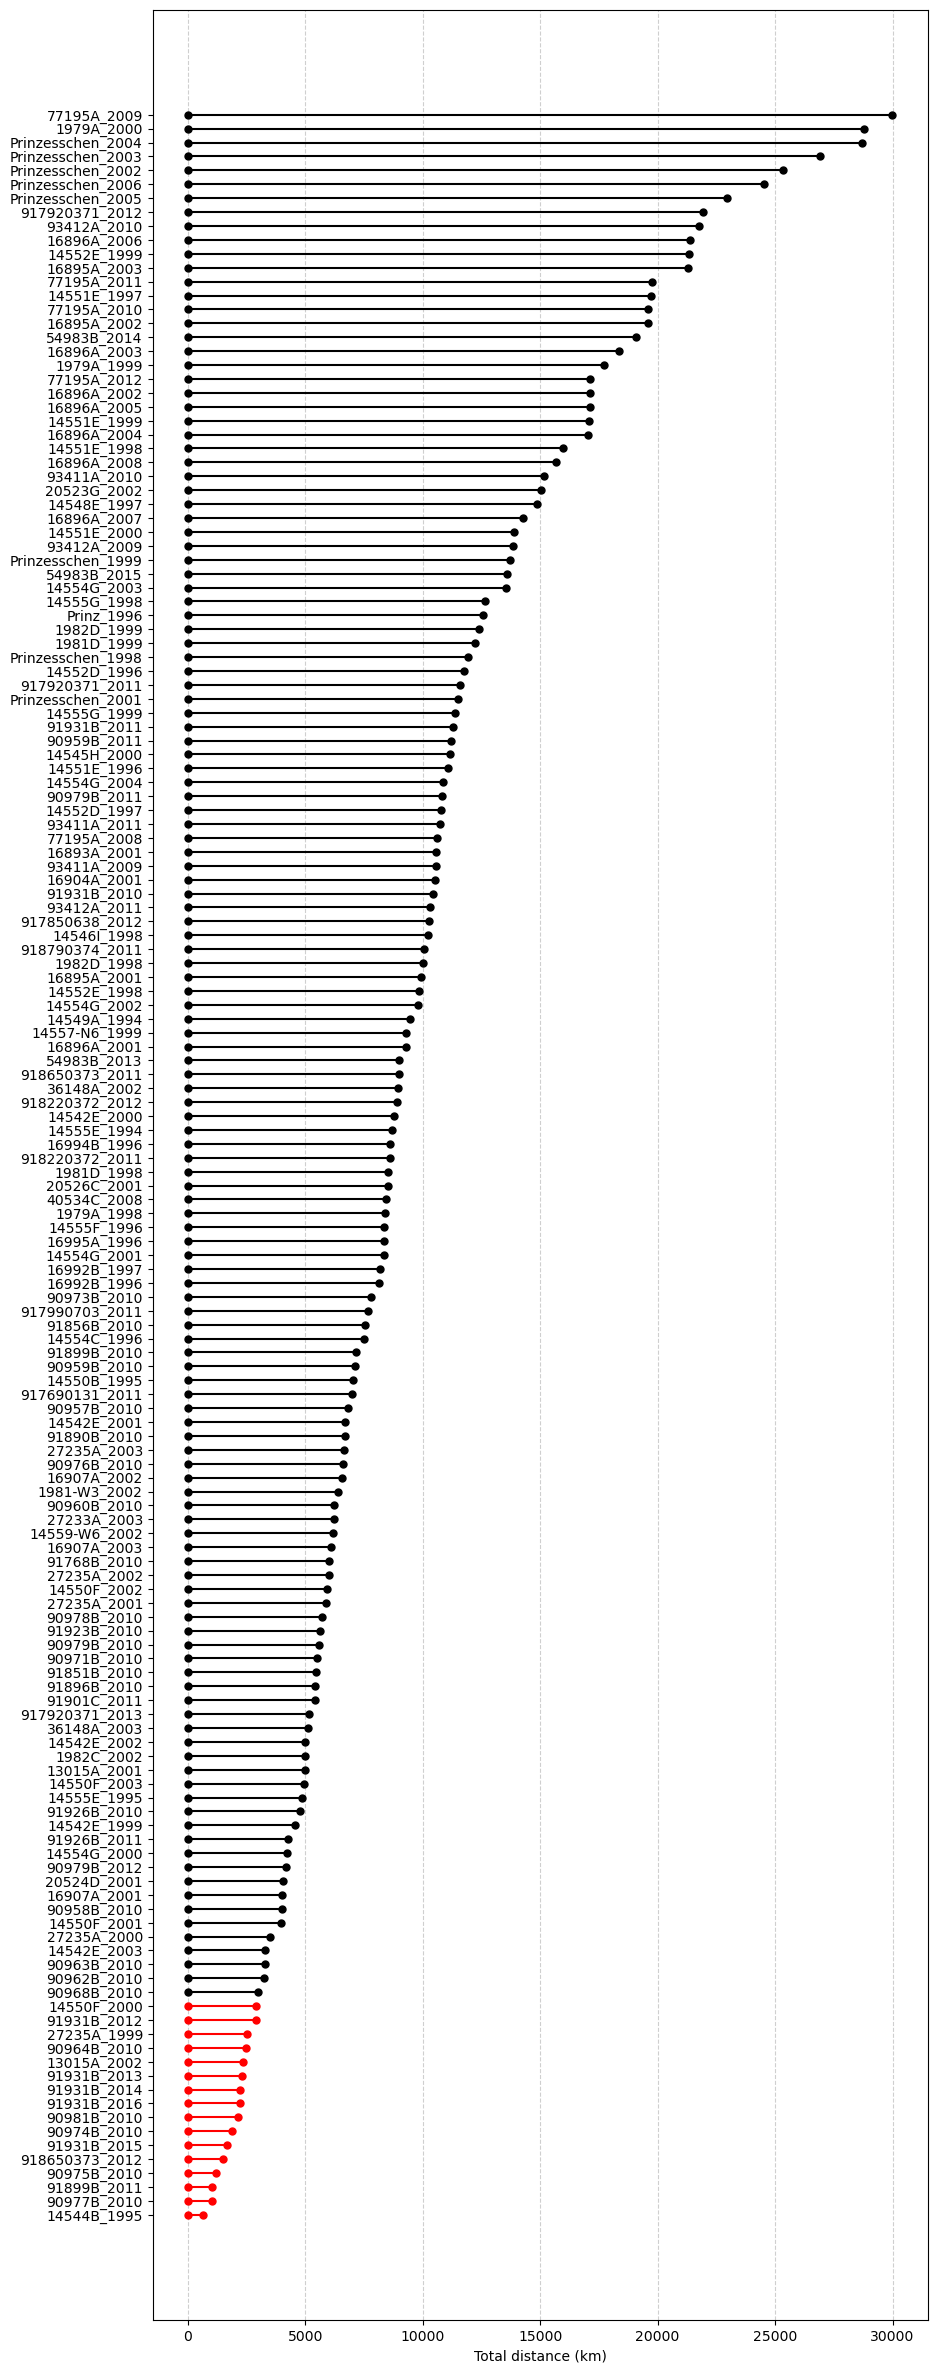

In [39]:
distance_covered_individuals = data_one_per_day_filter[['id_year', 'distance_from_last']].groupby(['id_year']).sum()

distance_covered_individuals.sort_values(by='distance_from_last', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(10, 30))


for idx, row in distance_covered_individuals.iterrows():
    if row['distance_from_last'] < 3000:
        ax.plot([0, row['distance_from_last']], [idx, idx], c = "red", marker='o', markersize=5)
    else: 
        ax.plot([0, row['distance_from_last']], [idx, idx], 'k-', marker='o', markersize=5)

ax.set_yticks(range(len(distance_covered_individuals)))
ax.set_yticklabels(distance_covered_individuals.index)

ax.set_xlabel('Total distance (km)')
ax.set_title('')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Removing all the 'individuals' who moved less than 3000 km overall.

In [40]:
data_one_per_day_filter = data_one_per_day_filter[data_one_per_day_filter['id_year'].isin(distance_covered_individuals[distance_covered_individuals['distance_from_last'] >= 3000].index)]

In [41]:
#data_one_per_day_filter.to_csv('data/stork_tracking_1perday_filter.csv')

In [42]:
data_one_per_day_filter.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last
timestamp,,,,,,,,,,,
2001-05-25 21:44:15,155977183,12.050,52.095,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,0.000000
2001-05-26 17:00:28,155977205,12.090,52.120,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,3.904943
2001-05-27 07:31:25,155977222,12.090,52.082,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,4.228232
2001-07-19 16:53:17,155977247,20.785,55.085,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,665.140144
2001-08-05 14:59:02,155977271,49.973,53.253,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,11.655827
